In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import re
import html
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import datetime
import os
import glob
import json
import time
from community import community_louvain
import seaborn as sns
from tqdm.notebook import tqdm
working_directory = 'C:/Users/Mao/sharedfiles/Side project/census-network-analysis'
os.chdir(working_directory)
twitter_files = glob.glob('C:/Users/Mao/sharedfiles/P Data/*.csv')
import warnings
warnings.filterwarnings("ignore")


# Preparing for the community detection

## Load the data

In [88]:
twitter_files = sorted(twitter_files)
twitter = pd.DataFrame()
for files in tqdm(twitter_files):
    data = pd.read_csv(files,low_memory=False)[['OriginalAuthor','Day','Message','MessageType','SenderScreenName']]
    twitter = twitter.append(data)

  0%|          | 0/258 [00:00<?, ?it/s]

## Only retweet network

In [89]:
retweets = twitter.loc[twitter['MessageType']=='Twitter Retweet']

In [90]:
#Convert the date to week
retweets.date = pd.to_datetime(retweets.Day)
retweets['week'] = retweets.date.dt.week

## Impute the missing original author

In [91]:
retweets['retweet_author'] = retweets.Message.str.extract(r'(RT @.*?\s)')

retweets.retweet_author = retweets.retweet_author.str.extract(r'([^@]*$)')

retweets.retweet_author = retweets['retweet_author'].str.extract(r'(\S*)')

In [20]:
retweets = retweets.loc[retweets['Day']>'2020-03-08',:]

# Louvain Community detection algorithm

In [10]:


community= pd.DataFrame()
for i in tqdm(range(11,39,1)):

    week_tweets = retweets.loc[(retweets['week']==i),:] #Create the retweet network perweek
    G = nx.DiGraph() 
    for index, row in week_tweets.iterrows():
        G.add_edge(row['SenderScreenName'], row['retweet_author']) # Construct the retweet network
    comm = community_louvain.best_partition(G.to_undirected())# run community detection algorithm
    commdf = pd.DataFrame.from_dict(comm, orient='index').reset_index().rename(columns={0:'community','index':'users'}) #create the user list with corrsponding community
    
    top10commidx = list(commdf.groupby('community').count().sort_values('users',ascending=False)[:10].index) # pick the 10 largest community
    top10comm = commdf.loc[commdf['community'].isin(top10commidx),:]
    indegree = dict(G.in_degree()) #Calculate the indegree for weighting
    top10comm = top10comm.merge(pd.DataFrame.from_dict(indegree,orient='index').reset_index().rename(columns={0:'in_degree','index':'users'}),on='users',how='left')
    top10comm['Week'] = i #Assign the week to the communities list
    community = community.append(top10comm)



  0%|          | 0/28 [00:00<?, ?it/s]

C:\Users\Mao\AppData\Local\Temp/ipykernel_15216/225523827.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  community = community.append(top10comm)
C:\Users\Mao\AppData\Local\Temp/ipykernel_15216/225523827.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  community = community.append(top10comm)
C:\Users\Mao\AppData\Local\Temp/ipykernel_15216/225523827.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  community = community.append(top10comm)
C:\Users\Mao\AppData\Local\Temp/ipykernel_15216/225523827.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  community = community.append(top10comm)
C:\Users\Mao\AppData\Local\Temp/ipykerne

In [191]:
topic = pd.DataFrame(columns=['community','week'])
idx=0
for i in range(11,39):
    week_comm = community.loc[community['Week']==i,:]
    for curComm in week_comm['community'].unique():
        topic.loc[idx,'community'] = curComm
        topic.loc[idx,'week'] = i
        idx+=1


In [11]:
community

,users,community,in_degree,Week
0,AmBeautifulShow,1,0,11
1,uscensusbureau,1,3117,11
2,stageofgrace,2,0,11
3,sesamestreet,2,664,11
4,Tosoccermom,2,0,11
...,...,...,...,...
8521,HarriganCasey,1,0,38
8522,britterkitters,1,0,38
8523,gamefish42,28,0,38
8524,Mr_Showbusiness,7,0,38


# Convert the dataframe to community-user matrix and weight user by their indegree

In [12]:

communities = []
for i in tqdm(range(1,39)):
    week_comm = community.loc[community['Week']==i,:]
    for curComm in tqdm(week_comm['community'].unique()):
        curComms = []
        for curUser in list(week_comm.loc[week_comm['community']==curComm,'users']):
            # Weight user by their indegree
            for j in range(0,(week_comm.loc[week_comm['users']==curUser,'in_degree']+1).reset_index(drop=True)[0]):
                curComms.append(curUser)
        communities.append(curComms)

  0%|          | 0/38 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [73]:
#Implement IDA to the communites
from gensim.models.ldamodel import LdaModel
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
common_dictionary = Dictionary(communities)
common_corpus = [common_dictionary.doc2bow(text) for text in communities]

In [152]:
#Implement IDA to the communites
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
# Create a corpus from a list of texts
common_dictionary = Dictionary(community_modu)
common_corpus = [common_dictionary.doc2bow(text) for text in community_modu]
# Train the model on the corpus.
for num in range(4,14):
    lda = LdaModel(common_corpus, num_topics=num,id2word=common_dictionary,minimum_probability=0.01,passes=10)
    print(lda.show_topics())

[(0, '0.045*"uscensusbureau" + 0.044*"BarackObama" + 0.021*"ChelseaClinton" + 0.018*"RealJamesWoods" + 0.015*"MarshaBlackburn" + 0.013*"bennyjohnson" + 0.013*"dbongino" + 0.012*"jedshug" + 0.010*"NBCNews" + 0.009*"EricTrump"'), (1, '0.117*"hansilowang" + 0.053*"charliekirk11" + 0.019*"liberalsrock2" + 0.009*"hultmark_mark" + 0.009*"kat__stafford" + 0.009*"crampell" + 0.007*"jbendery" + 0.007*"uscensusbureau" + 0.006*"matthewamiller" + 0.005*"JAYVERSACE"'), (2, '0.026*"realDonaldTrump" + 0.015*"ArianaGrande" + 0.011*"SenKamalaHarris" + 0.010*"TravisAllen02" + 0.009*"staceyabrams" + 0.008*"hansilowang" + 0.007*"vanitaguptaCR" + 0.007*"CACensus" + 0.006*"RepValDemings" + 0.005*"NALEO"'), (3, '0.114*"Sensational_Dre" + 0.045*"NewYorkStateAG" + 0.016*"jgeltzer" + 0.013*"ACLU" + 0.013*"AndrewYang" + 0.009*"SenWarren" + 0.009*"MSNBC" + 0.008*"kylegriffin1" + 0.008*"CNNPolitics" + 0.008*"AriBerman"')]
[(0, '0.032*"ArianaGrande" + 0.013*"jbendery" + 0.011*"uscensusbureau" + 0.011*"crampell" + 0

[(0, '0.045*"SenKamalaHarris" + 0.028*"staceyabrams" + 0.012*"NALEO" + 0.008*"SenSchumer" + 0.008*"SenFeinstein" + 0.008*"JoeBiden" + 0.008*"vanitaguptaCR" + 0.008*"johncardillo" + 0.008*"iamcardib" + 0.007*"Amy_Siskind"'), (1, '0.201*"Sensational_Dre" + 0.080*"uscensusbureau" + 0.034*"RealJamesWoods" + 0.012*"USATODAY" + 0.007*"jilevin" + 0.007*"JAYVERSACE" + 0.006*"KristenClarkeJD" + 0.004*"irishrygirl" + 0.004*"sydneyleroux" + 0.003*"tomTMwolf"'), (2, '0.103*"BarackObama" + 0.087*"NewYorkStateAG" + 0.030*"TravisAllen02" + 0.020*"ryanstruyk" + 0.016*"MSNBC" + 0.015*"tressiemcphd" + 0.014*"jgeltzer" + 0.010*"matthewamiller" + 0.009*"HowleyReporter" + 0.009*"ACLU"'), (3, '0.027*"AndrewYang" + 0.021*"EricTrump" + 0.021*"ACLU" + 0.017*"SenWarren" + 0.016*"kat__stafford" + 0.015*"CNNPolitics" + 0.015*"crampell" + 0.015*"kylegriffin1" + 0.014*"HerschelWalker" + 0.014*"dbongino"'), (4, '0.050*"ArianaGrande" + 0.039*"liberalsrock2" + 0.014*"vanitaguptaCR" + 0.013*"ShelbyKStewart" + 0.012*"th

In [249]:
lda = LdaModel(common_corpus, num_topics=3,id2word=common_dictionary,minimum_probability=0.01,passes=5)
print(lda.print_topics())

[(0, '0.105*"Sensational_Dre" + 0.032*"realDonaldTrump" + 0.021*"ChelseaClinton" + 0.018*"ArianaGrande" + 0.015*"jgeltzer" + 0.012*"dbongino" + 0.012*"jedshug" + 0.011*"AndrewYang" + 0.008*"ryanstruyk" + 0.007*"wdunlap"'), (1, '0.048*"BarackObama" + 0.046*"NewYorkStateAG" + 0.016*"MarshaBlackburn" + 0.014*"SenKamalaHarris" + 0.010*"uscensusbureau" + 0.010*"NBCNews" + 0.010*"EricTrump" + 0.010*"CNNPolitics" + 0.008*"BradleyWhitford" + 0.007*"kat__stafford"'), (2, '0.086*"hansilowang" + 0.037*"charliekirk11" + 0.035*"uscensusbureau" + 0.016*"RealJamesWoods" + 0.013*"liberalsrock2" + 0.012*"bennyjohnson" + 0.011*"TravisAllen02" + 0.008*"staceyabrams" + 0.008*"vanitaguptaCR" + 0.007*"stevenportnoy"')]


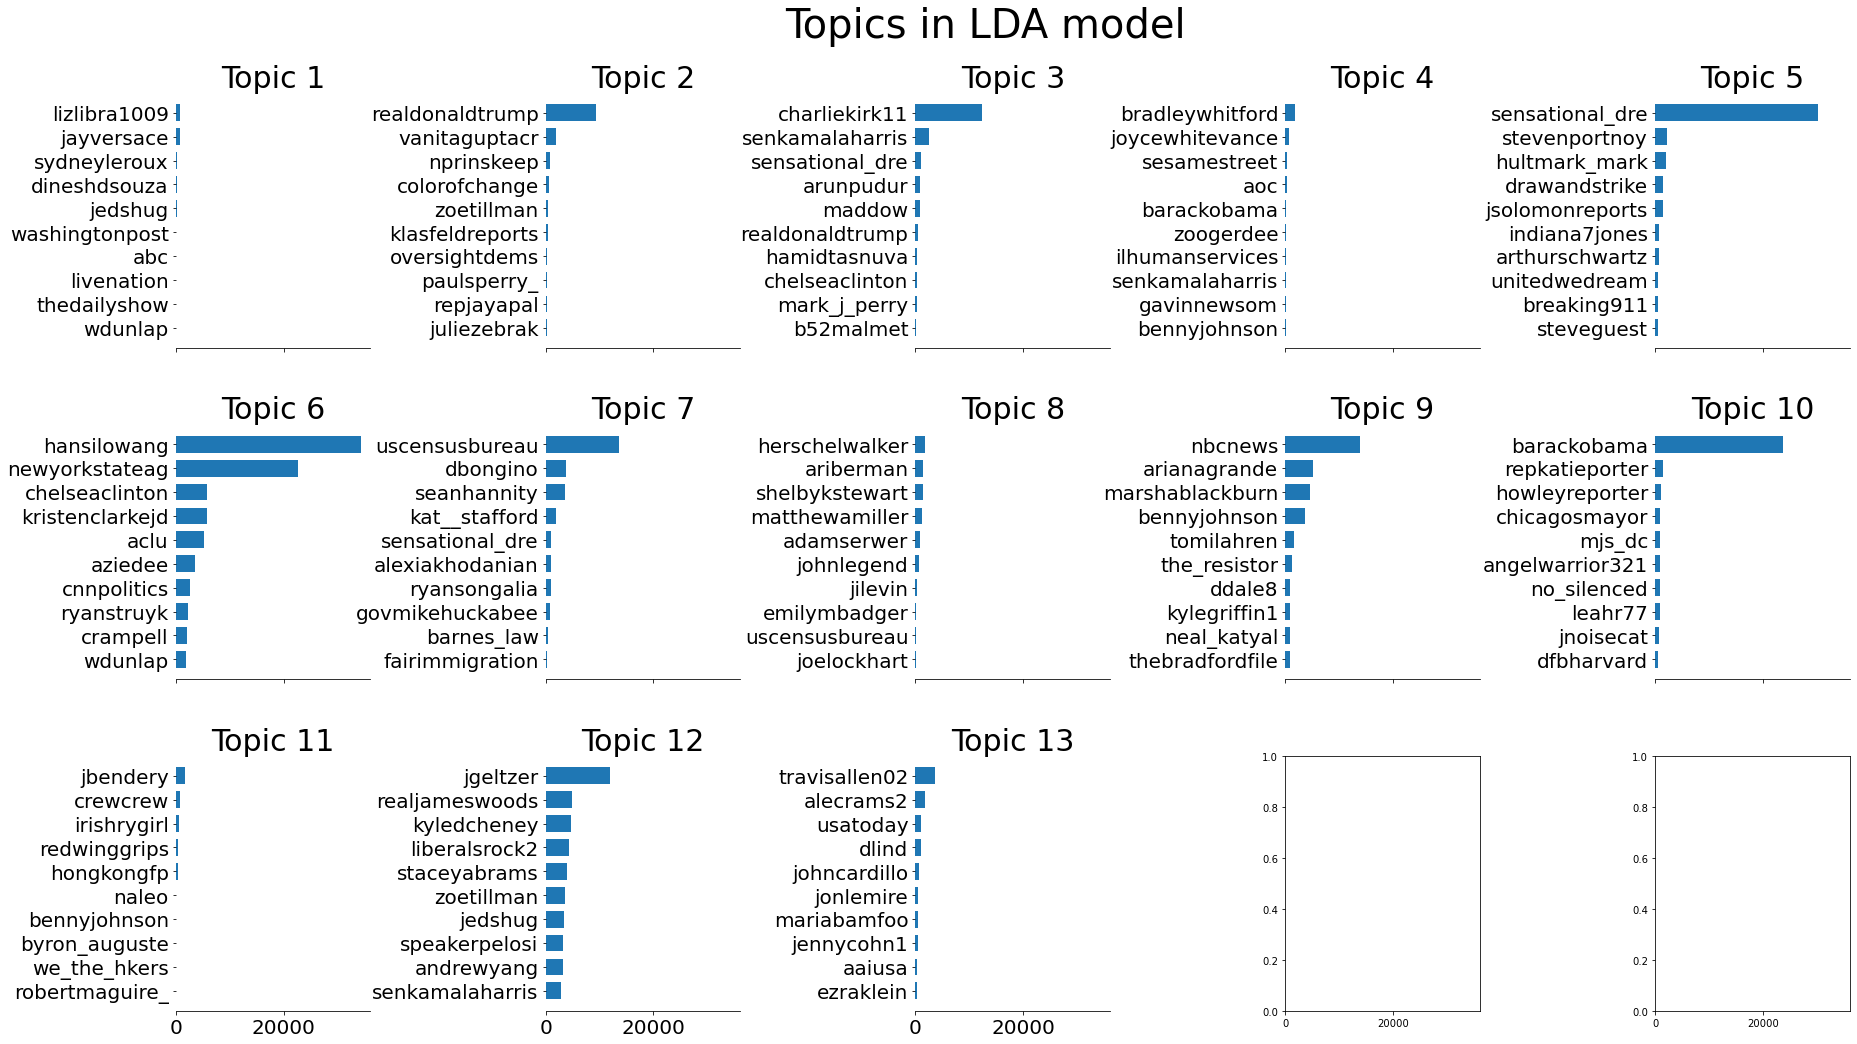

NameError: name 'n_components' is not defined

In [27]:
def plot_top_words(model, n_component, feature_names, n_top_words, title):

    fig, axes = plt.subplots(n_component//5+1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

lda = LatentDirichletAllocation(
    n_components=13,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)

lda.fit(count)


tf_feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda,13, tf_feature_names, 10, "Topics in LDA model")

In [ ]:
#Implement IDA to the communites
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
# Create a corpus from a list of texts
common_dictionary = Dictionary(communities)
common_corpus = [common_dictionary.doc2bow(text) for text in communities]
# Train the model on the corpus.
for num in range(4,14):
    globals()[f"lda{num}"]  = LdaModel(common_corpus, num_topics=num,id2word=common_dictionary,minimum_probability=0.01,passes=5)
    print(globals()[f"lda{num}"].show_topics(num_words = 5))

In [ ]:
import numpy as np
for x in range(4,14):
    idx = 0
    globals()[f"lda{x}"]=LdaModel.load('/Users/maoli/Documents/census-network-analysis/ldamodel/'+'lda_model_num_topic'+str(x))
    for i in globals()[f"lda{x}"].get_document_topics(common_corpus,minimum_probability=0.5):
        try:
            topic.loc[idx,'Topic'+str(x)] = i[0][0]
        except:
            topic.loc[idx,'Topic'+str(x)] = np.nan
        idx+=1

## Save models and results

In [ ]:
overall_daily = pd.read_excel(r"C:\Users\Mao\Downloads\Response Rate File with NRFU.xlsx",sheet_name='National Rate')
overall_daily['Self‐Response Rate '].sort_values(ascending=False).diff()
overall_daily['DRRINT'] = overall_daily['Self‐Response Rate '].diff()
overall_daily.loc[0,'DRRINT'] = 0.026
overall_daily['Date'] = pd.to_datetime(overall_daily['Date'])

overall_daily = overall_daily.loc[(overall_daily['Date']<='2020-09-14')&(overall_daily['Date']>='2020-03-20')]


In [13]:
community=pd.read_csv(r"C:\Users\Mao\sharedfiles\Side project\census-network-analysis\communities\communites_wcluster.csv")

In [14]:
community['Day'] = pd.to_datetime(community['Day'])

(array([18322., 18353., 18383., 18414., 18444., 18475., 18506.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

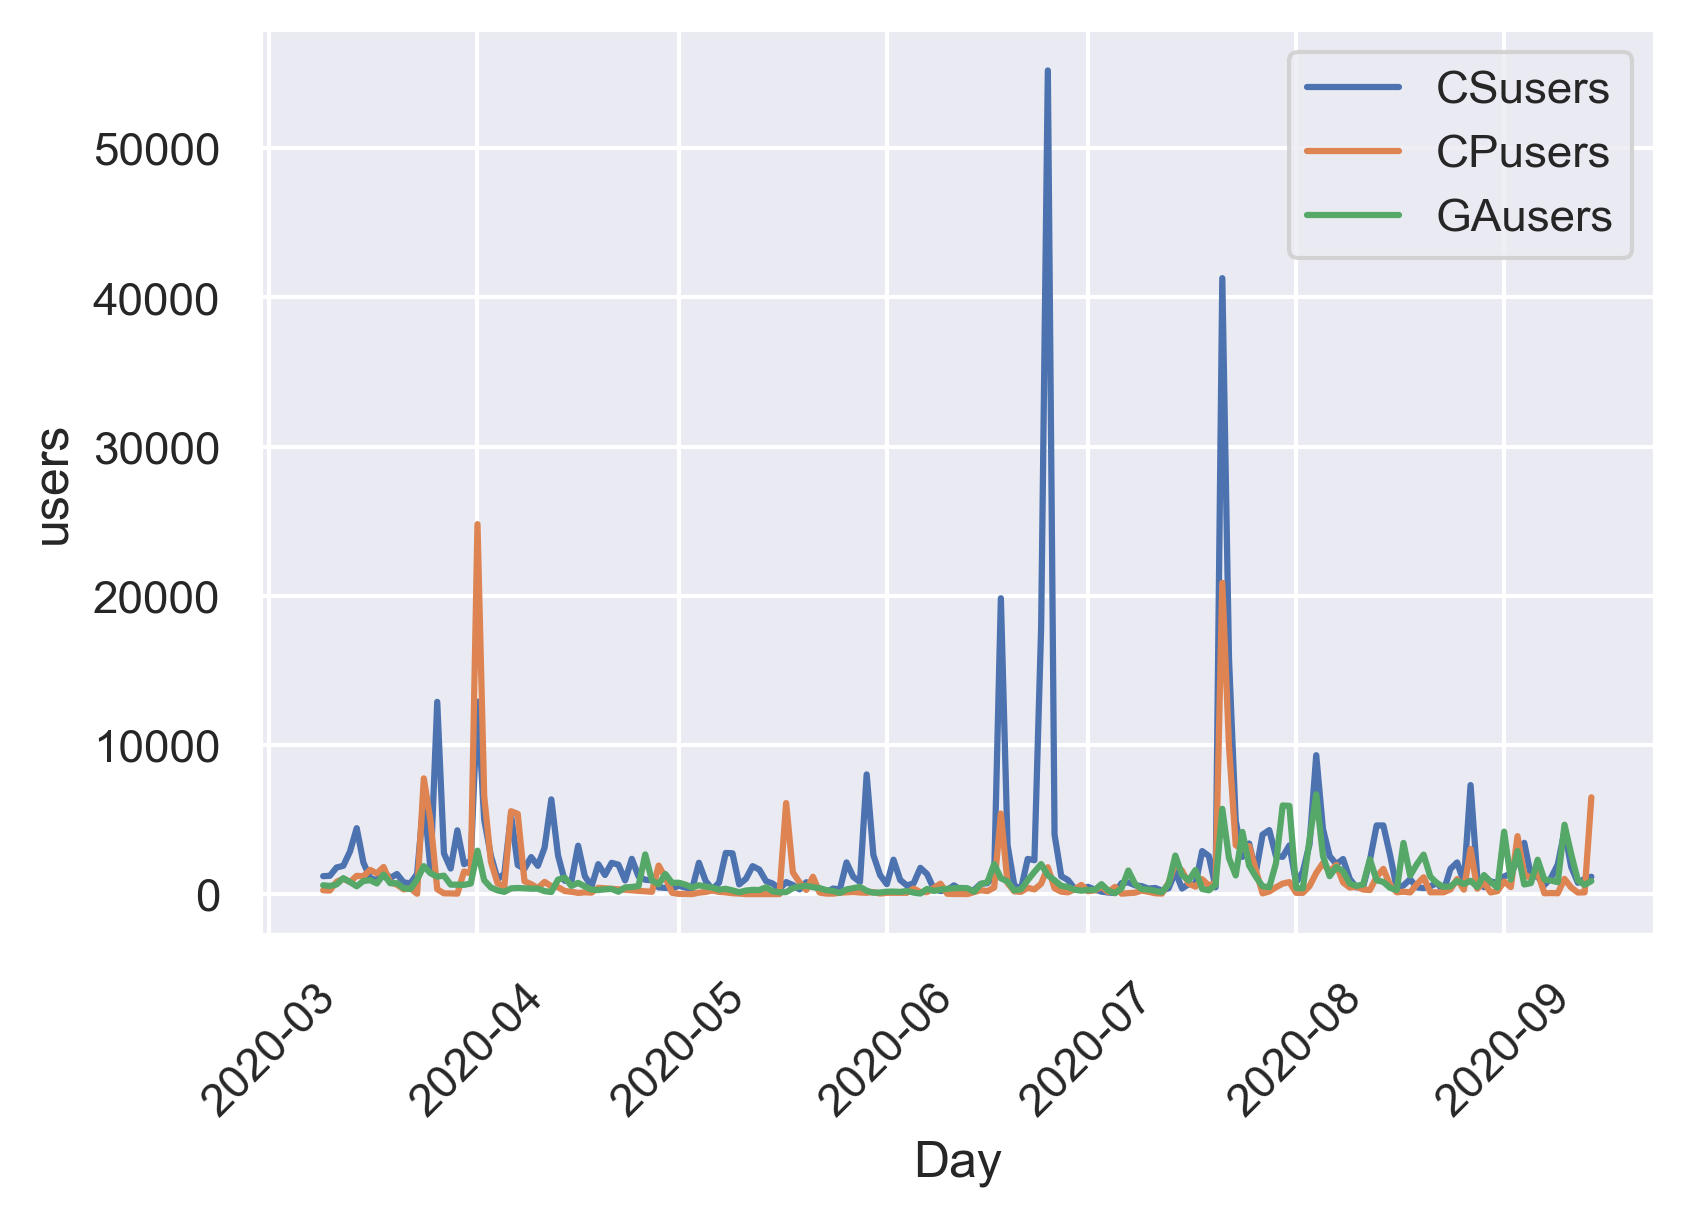

In [10]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

sns.lineplot(data=community.loc[community['cluster']==0,:].groupby('Day').nunique()[['users']].reset_index(),x='Day',y='users',label='CSusers')

sns.lineplot(data=community.loc[community['cluster']==2,:].groupby('Day').nunique()[['users']].reset_index(),x='Day',y='users',label='CPusers')
sns.lineplot(data=community.loc[community['cluster']==1,:].groupby('Day').nunique()[['users']].reset_index(),x='Day',y='users',label='GAusers')
plt.xticks(
    rotation=45
)



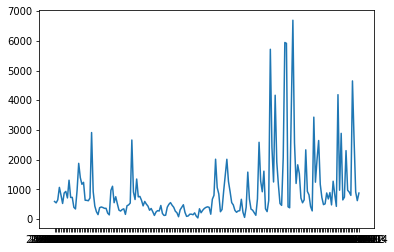

In [33]:
plt.plot(community.loc[community['cluster']==1,:].groupby('Day').nunique()[['users']])



(array([-25.,   0.,  25.,  50.,  75., 100., 125., 150., 175., 200.]),
 [Text(-25.0, 0, '2020-08-21'),
  Text(0.0, 0, '2020-03-09'),
  Text(25.0, 0, '2020-04-03'),
  Text(50.0, 0, '2020-05-05'),
  Text(75.0, 0, '2020-05-31'),
  Text(100.0, 0, '2020-06-27'),
  Text(125.0, 0, '2020-07-22'),
  Text(150.0, 0, '2020-08-16'),
  Text(175.0, 0, '2020-09-10'),
  Text(200.0, 0, '')])

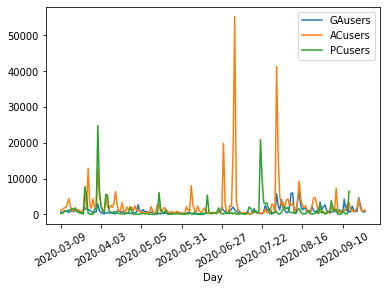

In [39]:
ax = community.loc[community['cluster']==1,:].groupby('Day').nunique()[['users']].rename(columns={'users':'GAusers'}).plot()
community.loc[community['cluster']==0,:].groupby('Day').nunique()[['users']].rename(columns={'users':'ACusers'}).plot(ax=ax)
community.loc[community['cluster']==2,:].groupby('Day').nunique()[['users']].rename(columns={'users':'PCusers'}).plot(ax=ax)
plt.xticks(rotation=30)

<AxesSubplot:xlabel='Day'>

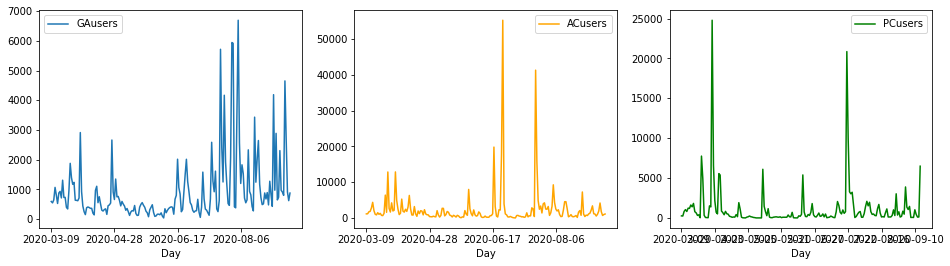

In [56]:

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(16,4))
community.loc[community['cluster']==1,:].groupby('Day').nunique()[['users']].rename(columns={'users':'GAusers'}).plot(ax=ax1)

community.loc[community['cluster']==0,:].groupby('Day').nunique()[['users']].rename(columns={'users':'ACusers'}).plot(ax=ax2,color='orange')

community.loc[community['cluster']==2,:].groupby('Day').nunique()[['users']].rename(columns={'users':'PCusers'}).plot(ax=ax3,color='green')





(array([-25.,   0.,  25.,  50.,  75., 100., 125., 150., 175., 200.]),
 [Text(-25.0, 0, '2020-08-21'),
  Text(0.0, 0, '2020-03-09'),
  Text(25.0, 0, '2020-04-03'),
  Text(50.0, 0, '2020-04-28'),
  Text(75.0, 0, '2020-05-23'),
  Text(100.0, 0, '2020-06-17'),
  Text(125.0, 0, '2020-07-12'),
  Text(150.0, 0, '2020-08-06'),
  Text(175.0, 0, '2020-08-31'),
  Text(200.0, 0, '')])

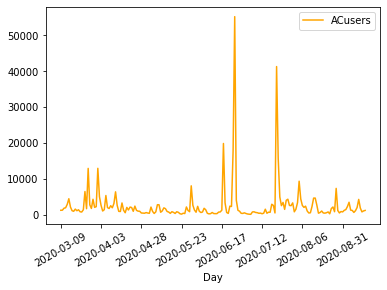

In [44]:
community.loc[community['cluster']==0,:].groupby('Day').nunique()[['users']].rename(columns={'users':'ACusers'}).plot(color='orange')

plt.xticks(rotation=30)

(array([-25.,   0.,  25.,  50.,  75., 100., 125., 150., 175., 200.]),
 [Text(-25.0, 0, '2020-08-21'),
  Text(0.0, 0, '2020-03-09'),
  Text(25.0, 0, '2020-04-03'),
  Text(50.0, 0, '2020-05-05'),
  Text(75.0, 0, '2020-05-31'),
  Text(100.0, 0, '2020-06-27'),
  Text(125.0, 0, '2020-07-22'),
  Text(150.0, 0, '2020-08-16'),
  Text(175.0, 0, '2020-09-10'),
  Text(200.0, 0, '')])

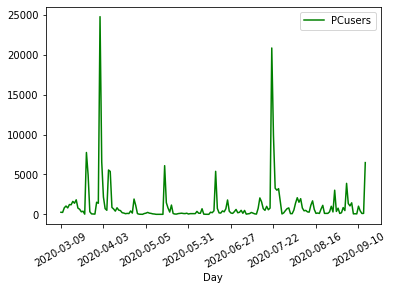

In [57]:
community.loc[community['cluster']==2,:].groupby('Day').nunique()[['users']].rename(columns={'users':'PCusers'}).plot(color='green')

plt.xticks(rotation=30)

In [40]:
overall_daily_copy= overall_daily.copy()
GAcluster = community.loc[community['cluster']==1,:].groupby('Day').nunique()[['users']].reset_index()

GAcluster.rename(columns={'users':'usersGA'},inplace=True)
overall_daily_copy_GA=overall_daily_copy.merge(GAcluster,left_on='Date',right_on='Day',how='left')




overall_daily_copy_GA=overall_daily_copy_GA.sort_values(by='Date').fillna(0)
from statsmodels.tsa.stattools import adfuller

result = adfuller(overall_daily_copy_GA['usersGA'])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'critical_values: {result[4]}')

from statsmodels.tsa.stattools import adfuller
result = adfuller(overall_daily_copy_GA['DRRINT'])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'critical_values: {result[4]}')

from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(overall_daily_copy_GA[['usersGA', 'DRRINT']], maxlag=[3])

from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(overall_daily_copy_GA[['DRRINT', 'usersGA']], maxlag=[3])

Test Statistics: -4.588050511364795
p-value: 0.0001358813217025405
critical_values: {'1%': -3.4851223522012855, '5%': -2.88553750045158, '10%': -2.5795685622144586}
Test Statistics: -4.428585964742295
p-value: 0.0002641000425595632
critical_values: {'1%': -3.4880216384691867, '5%': -2.8867966864160075, '10%': -2.5802408234244947}

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2781  , p=0.8411  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=0.8854  , p=0.8290  , df=3
likelihood ratio test: chi2=0.8822  , p=0.8297  , df=3
parameter F test:         F=0.2781  , p=0.8411  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1381  , p=0.3368  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=3.6239  , p=0.3051  , df=3
likelihood ratio test: chi2=3.5706  , p=0.3117  , df=3
parameter F test:         F=1.1381  , p=0.3368  , df_denom=114, df_num=3


{3: ({'ssr_ftest': (1.1380696197260658, 0.33683223759034664, 114.0, 3),
   'ssr_chi2test': (3.623853262811947, 0.30505044826930594, 3),
   'lrtest': (3.570647218050908, 0.31171434254570046, 3),
   'params_ftest': (1.1380696198790268, 0.3368322375297608, 114.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

In [50]:
overall_daily_copy= overall_daily.copy()
PCcluster = community.loc[community['cluster']==2,:].groupby('Day').nunique()[['users']].reset_index()

PCcluster.rename(columns={'users':'usersPC'},inplace=True)

overall_daily_copy_PC=overall_daily_copy.merge(PCcluster,left_on='Date',right_on='Day',how='left')




overall_daily_copy_PC=overall_daily_copy_PC.sort_values(by='Date').fillna(0)
from statsmodels.tsa.stattools import adfuller

result = adfuller(overall_daily_copy_PC['usersPC'])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'critical_values: {result[4]}')

from statsmodels.tsa.stattools import adfuller
result = adfuller(overall_daily_copy_PC['DRRINT'])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'critical_values: {result[4]}')

from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(overall_daily_copy_PC[['usersPC', 'DRRINT']], maxlag=[3])

from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(overall_daily_copy_PC[['DRRINT', 'usersPC']], maxlag=[3])

Test Statistics: -4.034280128023432
p-value: 0.0012412736539520865
critical_values: {'1%': -3.4865346059036564, '5%': -2.8861509858476264, '10%': -2.579896092790057}
Test Statistics: -4.428585964742295
p-value: 0.0002641000425595632
critical_values: {'1%': -3.4880216384691867, '5%': -2.8867966864160075, '10%': -2.5802408234244947}

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.0060  , p=0.0333  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=9.5719  , p=0.0226  , df=3
likelihood ratio test: chi2=9.2121  , p=0.0266  , df=3
parameter F test:         F=3.0060  , p=0.0333  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=21.1357 , p=0.0000  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=67.3007 , p=0.0000  , df=3
likelihood ratio test: chi2=53.5122 , p=0.0000  , df=3
parameter F test:         F=21.1357 , p=0.0000  , df_denom=114, df_num=3


{3: ({'ssr_ftest': (21.13574564264566, 5.86962343211843e-11, 114.0, 3),
   'ssr_chi2test': (67.30066375684538, 1.6147723374815072e-14, 3),
   'lrtest': (53.51217922185788, 1.425751910777715e-11, 3),
   'params_ftest': (21.135745645945853, 5.86962341372804e-11, 114.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

In [47]:
overall_daily_copy = overall_daily.copy()
ACcluster = community.loc[community['cluster']==0,:].groupby('Day').nunique()[['users']].reset_index()

ACcluster.rename(columns={'users':'usersAC'},inplace=True)
overall_daily_copy_AC=overall_daily_copy.merge(ACcluster,left_on='Date',right_on='Day',how='left')




overall_daily_copy_AC=overall_daily_copy_AC.sort_values(by='Date')
from statsmodels.tsa.stattools import adfuller

result = adfuller(overall_daily_copy_AC['usersAC'])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'critical_values: {result[4]}')

from statsmodels.tsa.stattools import adfuller
result = adfuller(overall_daily_copy_AC['DRRINT'])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'critical_values: {result[4]}')

from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(overall_daily_copy_AC[['usersAC', 'DRRINT']], maxlag=[3])

from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(overall_daily_copy_AC[['DRRINT', 'usersAC']], maxlag=[3])

Test Statistics: -9.888191758783483
p-value: 3.616579650447666e-17
critical_values: {'1%': -3.4846672514209773, '5%': -2.8853397507076006, '10%': -2.5794629869786503}
Test Statistics: -4.428585964742295
p-value: 0.0002641000425595632
critical_values: {'1%': -3.4880216384691867, '5%': -2.8867966864160075, '10%': -2.5802408234244947}

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.2951  , p=0.0231  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=10.4923 , p=0.0148  , df=3
likelihood ratio test: chi2=10.0621 , p=0.0180  , df=3
parameter F test:         F=3.2951  , p=0.0231  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.7660  , p=0.0127  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=11.9917 , p=0.0074  , df=3
likelihood ratio test: chi2=11.4340 , p=0.0096  , df=3
parameter F test:         F=3.7660  , p=0.0127  , df_denom=114, df_num=3


{3: ({'ssr_ftest': (3.7659863439662704, 0.012744436185903622, 114.0, 3),
   'ssr_chi2test': (11.991693358418914, 0.007411669784704279, 3),
   'lrtest': (11.43403109146152, 0.009596173615949081, 3),
   'params_ftest': (3.765986342905619, 0.012744436202970453, 114.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

## Visualize the Causality

<AxesSubplot:>

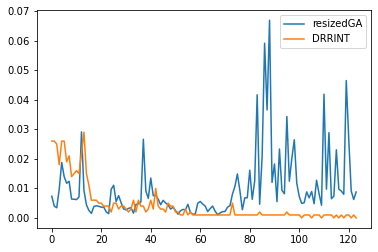

In [44]:
overall_daily_copy_GA['resizedGA'] = (overall_daily_copy_GA['usersGA'])/100000
overall_daily_copy_GA[['resizedGA','DRRINT']].plot()

<AxesSubplot:>

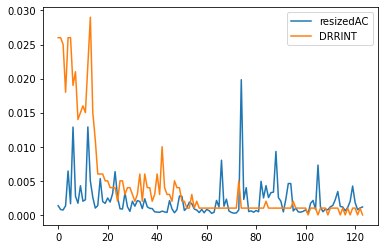

In [48]:
overall_daily_copy_AC['resizedAC'] = (overall_daily_copy_AC['usersAC'])/1000000
overall_daily_copy_AC[['resizedAC','DRRINT']].plot()

<AxesSubplot:>

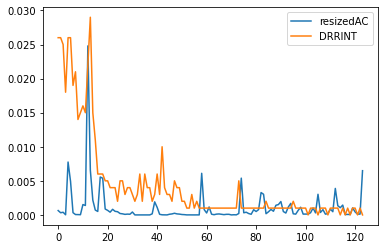

In [53]:
overall_daily_copy_PC['resizedAC'] = (overall_daily_copy_PC['usersPC'])/1000000
overall_daily_copy_PC[['resizedAC','DRRINT']].plot()

In [109]:
community.loc[community['cluster']==1,:].groupby('users').sum().soddrt_values(by='in_degree',ascending=False)[:10]

,community,in_degree,Week,cluster
users,,,,
hansilowang,1289659,785244874,2701567,87681
NewYorkStateAG,2901713,235213825,1018460,30526
EricTrump,390600,38371800,192200,6200
NALEO,268592,10112487,148662,5093
HowleyReporter,587930,6962115,53120,3095
arunpudur,105978,4313928,68574,2078
kyledcheney,35442,3873023,72853,1969
ArthurSchwartz,0,2987706,53661,1731
SharletaBasset1,254538,2012130,48348,1422


In [111]:
community.loc[community['cluster']==2,:].groupby('users').sum().sort_values(by='in_degree',ascending=False)[:10]

,community,in_degree,Week,cluster
users,,,,
BarackObama,1586056,637569302,550272,60646
ChelseaClinton,3109718,217164430,191594,29476
liberalsrock2,10309,106213627,154635,20618
AndrewYang,1612269,42296580,158292,15678
NBCNews,18713,34420237,233870,12742
SenWarren,111607,22967496,157640,10926
kat__stafford,415007,21734243,65282,9326
SenKamalaHarris,149775,20240014,199990,17474
MSNBC,163447,18375759,141602,8876


In [329]:
community.drop(columns=['cluster_x','cluster_y','cluster_x','cluster_y']).to_csv('/Users/maoli/Documents/census-network-analysis/communities/communites_wcluster.csv',index=False)

In [10]:
community_filtered

,users,community,in_degree,Week,cluster,Day
0,AmBeautifulShow,1,0,11,0,2020-03-09
2,uscensusbureau,1,3117,11,0,2020-03-09
3588,1mtheresa,1,0,11,0,2020-03-09
3589,ComcastNewsmkrs,1,124,11,0,2020-03-09
3713,VeronicaLucife,1,0,11,0,2020-03-09
...,...,...,...,...,...,...
2017384,HarriganCasey,1,0,38,2,2020-09-14
2017385,britterkitters,1,0,38,2,2020-09-14
2017386,gamefish42,30,0,38,0,2020-09-14
2017387,Mr_Showbusiness,7,0,38,0,2020-09-14


In [103]:
community_filtered_2nd = community_filtered.loc[community_filtered.users.isin(community_filtered.groupby('users').nunique()[community_filtered.groupby('users').nunique()['cluster']<=1].reset_index()['users']),:]

In [85]:
community_filtered.loc[community_filtered['cluster']==0,:].groupby('users').sum().sort_values(by='in_degree',ascending=False)[:10]

,community,in_degree,Week,cluster
users,,,,
Sensational_Dre,410,73930,26,0
uscensusbureau,511,32950,397,0
charliekirk11,360,28483,161,0
realDonaldTrump,415,22634,152,0
ArianaGrande,888,12615,69,0
RealJamesWoods,126,12315,57,0
MarshaBlackburn,42,10360,48,0
bennyjohnson,129,9057,61,0
dbongino,149,8904,107,0


In [104]:
community_filtered_2nd.loc[community_filtered_2nd['cluster']==0,:].groupby('users').sum().sort_values(by='in_degree',ascending=False)[:10]

,community,in_degree,Week,cluster
users,,,,
ArianaGrande,888,12615,69,0
RealJamesWoods,126,12315,57,0
MarshaBlackburn,42,10360,48,0
bennyjohnson,129,9057,61,0
dbongino,149,8904,107,0
TravisAllen02,4,8806,15,0
stevenportnoy,12,5219,61,0
tressiemcphd,6,4441,13,0
HerschelWalker,557,4276,103,0


In [113]:
community_filtered.loc[community_filtered['cluster']==1,:].groupby('users').sum().sort_values(by='in_degree',ascending=False)[:10]

,community,in_degree,Week,cluster
users,,,,
hansilowang,1507,66758,596,23
NewYorkStateAG,411,28593,135,4
EricTrump,63,6189,31,1
NALEO,539,4154,324,14
HowleyReporter,227,3093,35,2
CACensus,495,3083,264,12
arunpudur,51,2076,33,1
kyledcheney,18,1967,37,1
ArthurSchwartz,0,1726,31,1


In [112]:
community_filtered.loc[community_filtered['cluster']==2,:].groupby('users').sum().sort_values(by='in_degree',ascending=False)[:10]

,community,in_degree,Week,cluster
users,,,,
BarackObama,173,30257,85,6
ChelseaClinton,211,14735,13,2
liberalsrock2,1,10303,15,2
SenKamalaHarris,109,8332,105,10
AndrewYang,267,7835,41,4
NBCNews,35,6079,54,4
SenWarren,197,5423,71,6
kat__stafford,89,4661,14,2
AriBerman,125,4357,141,12
